In [6]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt
import numpy as np


#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20

class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
   
        self.fc1   = nn.Linear(4,256)
        self.fc_pi = nn.Linear(256,2)
        self.fc_v  = nn.Linear(256,1)
        

    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v
      
        
def make_batch():
    s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
    for transition in data:
        s, a, r, s_prime, prob_a, done = transition
        
        s_lst.append(s)
        a_lst.append([a])
        r_lst.append([r])
        s_prime_lst.append(s_prime)
        prob_a_lst.append([prob_a])
        done_mask = 0 if done else 1
        done_lst.append([done_mask])
            
    s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                      torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
                                      torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)

    return s, a, r, s_prime, done_mask, prob_a
        
        
def train(model,optimizer):
    s, a, r, s_prime, done_mask, prob_a = make_batch()

    for i in range(K_epoch):
        td_target = r + gamma * model.v(s_prime) * done_mask
        delta = td_target - model.v(s)
        delta = delta.detach().numpy()

        advantage_lst = []
        advantage = 0.0
        for delta_t in delta[::-1]:
            advantage = gamma * lmbda * advantage + delta_t[0]
            advantage_lst.append([advantage])
        advantage_lst.reverse()
        advantage = torch.tensor(advantage_lst, dtype=torch.float)

        pi = model.pi(s, softmax_dim=1)
        pi_a = pi.gather(1,a)
        ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == exp(log(a)-log(b))
        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
        loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(model.v(s) , td_target.detach())

        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()



#env = gym.make('LunarLander-v2')        
env = gym.make('CartPole-v1')
model = PPO()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


score = 0.0
print_interval = 20
scores = []
for n_epi in range(3000):
    s = env.reset()
    done = False
    data = []
    while not done:
        for t in range(T_horizon):
           
            prob = model.pi(torch.from_numpy(s).float())
            m = Categorical(prob)
            a = m.sample().item()
            s_prime, r, done, info = env.step(a)
            data.append((s, a, r/100.0, s_prime, prob[a].item(), done))
            s = s_prime

            score += r
            if done:
                break


        train(model,optimizer)
        data = []

    if n_epi%print_interval==0 and n_epi!=0:
        clear_output(wait=True)
        print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
        scores.append(score)
        score = 0.0

env.close()


# of episode :1980, avg score : 396.4


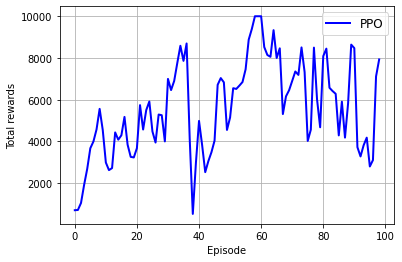

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(len(scores)), np.array(scores), 'b', linewidth = 2, label = 'PPO')
plt.legend(prop={'size':12})
plt.xlabel('Episode')
plt.ylabel('Total rewards')
#plt.xlim(0, no_of_episodes)
#plt.ylim(0, 20000)
#plt.legend(['Double DQN', 'Dueling DQN', 'D3QN'], loc=4)
plt.grid(True)

In [8]:
# TEST   
episode = 0
s = env.reset()    
score = 0
while episode < 3:  # episode loop
    env.render()
    prob = model.pi(torch.from_numpy(s).float())
    m = Categorical(prob)
    a = m.sample().item()
    s_prime, r, done, info = env.step(a)  # take a random action
    s = s_prime
    sleep(0.01)
    if done:
        env.close()
    score = score + r
    if done:
        episode = episode + 1
        print('Episode: {} Score: {}'.format(episode, score))
        state = env.reset()
env.close()    

Episode: 1 Score: 343.0
Episode: 2 Score: 719.0
Episode: 3 Score: 1147.0
